In [1]:
import numpy as np
import cv2
from custom_io import *

# Canny Edge Detection

```python
edges = cv2.Canny(img, 100, 200) # source, low, high
```
[Reference article](https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123)

In [2]:
I = cv2.imread("data/wikipedia_black.png", 0)

### Apply gaussian filter to smoothen the image

[`cv2.GuassianBlur()`](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#gae8bdcd9154ed5ca3cbc1766d960f45c1)

In [3]:
I_blurred = cv2.GaussianBlur(I, (5, 5), 5) # (k, k), sigma

### Compute the Gradient

Why do we set ddepth to `cv2.CV_32F`? [Read this](https://docs.opencv.org/4.x/d5/d0f/tutorial_py_gradients.html).

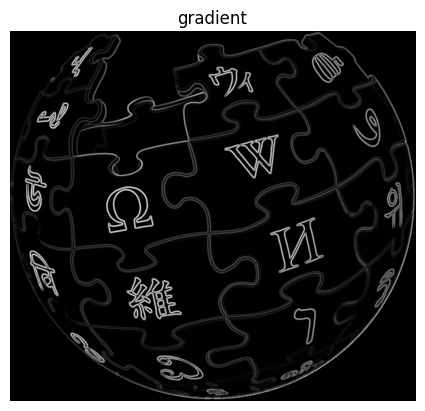

In [4]:
sobely = cv2.Sobel(src=I_blurred, ddepth=cv2.CV_32F, dx=0, dy=1)
sobelx = cv2.Sobel(src=I_blurred, ddepth=cv2.CV_32F, dx=1, dy=0)

G = np.hypot(sobelx, sobely)
theta = np.arctan2(sobely, sobelx)

plot_images(G, "gradient")

### Apply non-maxima supression

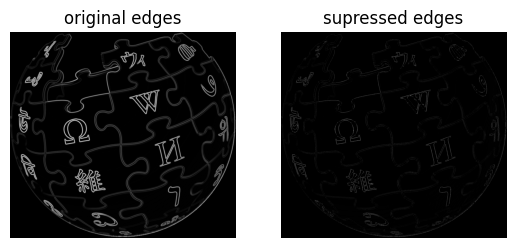

In [5]:
# output image with all zeroes initially
G_supressed = np.zeros_like(G) 

# convert all angles to  positive degrees
theta[theta < 0] += np.pi
theta = theta * 180 / np.pi

M, N = I.shape

for i in range(1, M - 1):
    for j in range(1, N - 1):
        angle = theta[i][j]

        if (0 <= angle < 22.5) or (157.5 < angle <= 180):
            q, r = G[i, j + 1], G[i, j - 1] # horizontal
        elif 67.5 <= angle <= 112.5:
            q, r = G[i + 1, j], G[i - 1, j] # vertical
        elif 22.5 <= angle < 67.5:
            q, r = G[i - 1, j + 1], G[i + 1, j - 1] # diagonal
        else:
            q, r = G[i + 1, j + 1], G[i - 1, j - 1] # anti-diagonal
    
        if G[i][j] >= max(q, r):
            G_supressed[i][j] = G[i][j]

plot_images(G, 'original edges', G_supressed, 'supressed edges')

### Use double thresholding and hysteresis

Merged the two steps into a single iteration

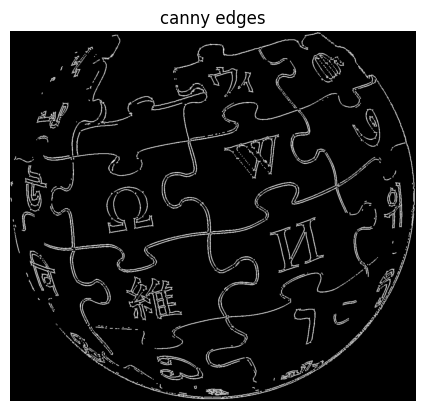

In [6]:
output = np.zeros_like(G)
L, H = 0, 75 # low and high thresholds

for i in range(1, M - 1):
    for j in range(1, N - 1):
        if G_supressed[i][j] < L:
            continue

        if G_supressed[i][j] >= H:
            output[i][j] = 255
            continue

        if any(
            G_supressed[x][y] >= H
            for x in (i - 1, i, i + 1)
            for y in (j - 1, j, j + 1)
        ):
            output[i][j] = 155

plot_images(output, 'canny edges')

# Otsu's thresholding

```python
threshold, result = cv2.threshold(wikipedia, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU, 255)
```

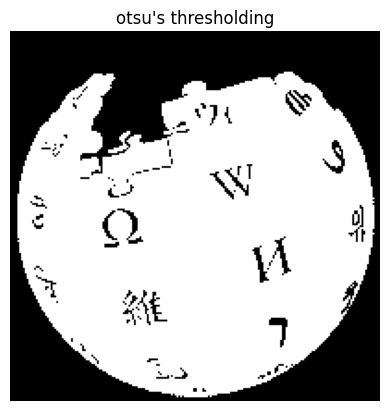

In [7]:
def otsu_threshold(I):
    hist, _ = np.histogram(I.flatten(), 256, (0, 256))
    M, N = I.shape
    pdf = hist / (M * N)
    cdf = np.cumsum(pdf)
    
    best_k, best_variance = 0, 0
    cumulative_mean = np.cumsum(np.arange(256) * pdf)
    
    for k in range(1, 255):
        P1 = cdf[k]
        P2 = 1 - P1
        if P1 == 0 or P2 == 0:
            continue
        
        m1 = cumulative_mean[k] / P1
        m2 = (cumulative_mean[-1] - cumulative_mean[k]) / P2
        
        variance = P1 * P2 * (m1 - m2) ** 2
        
        if variance > best_variance:
            best_k = k
            best_variance = variance
    
    _, T = cv2.threshold(I, best_k, 255, cv2.THRESH_BINARY)
    return T

wikipedia = cv2.imread('data/wikipedia.png', 0)
res = otsu_threshold(wikipedia)
plot_images(res, "otsu's thresholding")

# Hough lines

[Relevant StackOveflow post](https://stackoverflow.com/questions/4709725/explain-hough-transformation)


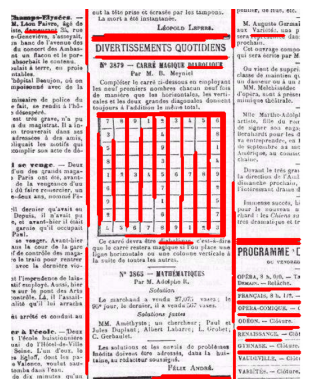

In [8]:
img = cv2.imread("data/sudoku.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(grey, 150, 200, 3)

lines = cv2.HoughLinesP(edges, rho=0.1, theta=np.pi/1800, threshold=100, minLineLength=50, maxLineGap=2)
for line in lines:
    x1,y1,x2,y2 = line[0]
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 3)
    
plot_images(img)

### Color segmentation

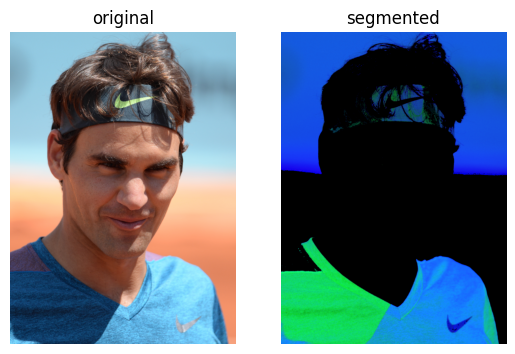

In [23]:
img = cv2.imread("data/roger.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

lower_red = np.array([0, 0, 0])
upper_red = np.array([50, 255, 255])
mask = cv2.inRange(hsv, lower_red, upper_red) 

result_img = cv2.bitwise_and(hsv, hsv, mask=mask)

plot_images(img, "original", result_img, "segmented")